# Comparison of different k-mer lengths

In [1]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from util import *

# set path to data folder
root = "F:/Studium/Master/semester5/thesis/data/dataset/"

# definition of the true positive species zymoMock
species_zymo_mock = {
    "Pseudomonas aeruginosa",
    "Escherichia coli",
    "Salmonella enterica",
    "Staphylococcus aureus",
    "Limosilactobacillus fermentum",
    "Enterococcus faecalis",
    "Listeria monocytogenes",
    "Bacillus subtilis",
    "Saccharomyces cerevisiae",
    "Cryptococcus neoformans"}

# definition of the true positive species zymoOral
species_zymo_oral = {
    "Streptococcus parasanguinis",
    "Veillonella parvula",
    "Neisseria subflava",
    "Prevotella nigrescens",
    "Streptococcus mitis",
    "Haemophilus parainfluenzae",
    "Schaalia odontolytica",
    "Rothia dentocariosa",
    "Streptococcus salivarius",
    "Fusobacterium nucleatum",
    "Streptococcus mutans",
    "Porphyromonas gingivalis"}

# total read count in zymoMock dataset
total_zymo_mock = 1_160_526
# total read count in zymoOral dataset
total_zymo_oral = 1_140_052
# reading the taxonomic tree
tree = Tree(root + "tree_nr.txt")
# generate dictionary with all taxa that are true positives for each taxonomic rank
true_taxons_zymo_mock = get_true_taxons_for_all_ranks(tree, species_zymo_mock)
true_taxons_zymo_oral = get_true_taxons_for_all_ranks(tree, species_zymo_oral)

KeyboardInterrupt: 

## Data zymoMock

In [2]:
# read table with paths to datasets and metadata
data_zymo_mock_metadata = pd.read_csv("datasets_zymo_mock_metadata.tsv", sep="\t", header=0).fillna("")
data_zymo_mock = pd.DataFrame()
data_zymo_mock_recall = pd.DataFrame()
for i, row in data_zymo_mock_metadata.iterrows():
    # read per taxon assignment files and keep taxa with at least one read assigned by the "OVO (1.00) read count cumulative" algorithm
    per_taxon_assignment = read_per_taxon_assignment(root + row.path, ovo_1_threshold=1)
    # classify taxa as true positive or false positive
    per_taxon_assignment = classify_assigned_taxa(per_taxon_assignment, true_taxons_zymo_mock)
    # calculate precision and recall
    per_taxon_assignment = get_precision_recall_for_algorithm(per_taxon_assignment, "OVO (1.00) kmer count (cumulative)", total_zymo_mock)
    per_taxon_assignment["k-mer size"] = row["kmer size"]
    data_zymo_mock = pd.concat([data_zymo_mock, per_taxon_assignment], ignore_index=True, axis=0)
    recall = per_taxon_assignment[["rank", "recall"]]\
                                 .melt(id_vars="rank").pivot_table(index=None, columns="rank", values="value")\
                                 .sort_values(by="value", axis=1, ascending=False).reset_index(drop=True)
    recall["label"] = row["kmer size"]
    data_zymo_mock_recall = pd.concat([data_zymo_mock_recall, recall], ignore_index=True, axis=0)
data_zymo_mock_recall

rank,superkingdom,kingdom,phylum,class,order,family,genus,species,label
0,0.996617,0.977368,0.914105,0.807840,0.740413,0.723929,0.634194,0.377472,11
1,0.989190,0.958919,0.904715,0.864212,0.846850,0.834136,0.728432,0.429685,12
2,0.964373,0.933922,0.893850,0.871550,0.860231,0.848611,0.735059,0.425613,13
3,0.927211,0.903394,0.874736,0.860741,0.850680,0.840136,0.724841,0.414431,14
4,0.903977,0.880692,0.853947,0.842427,0.832416,0.822453,0.708521,0.401434,15


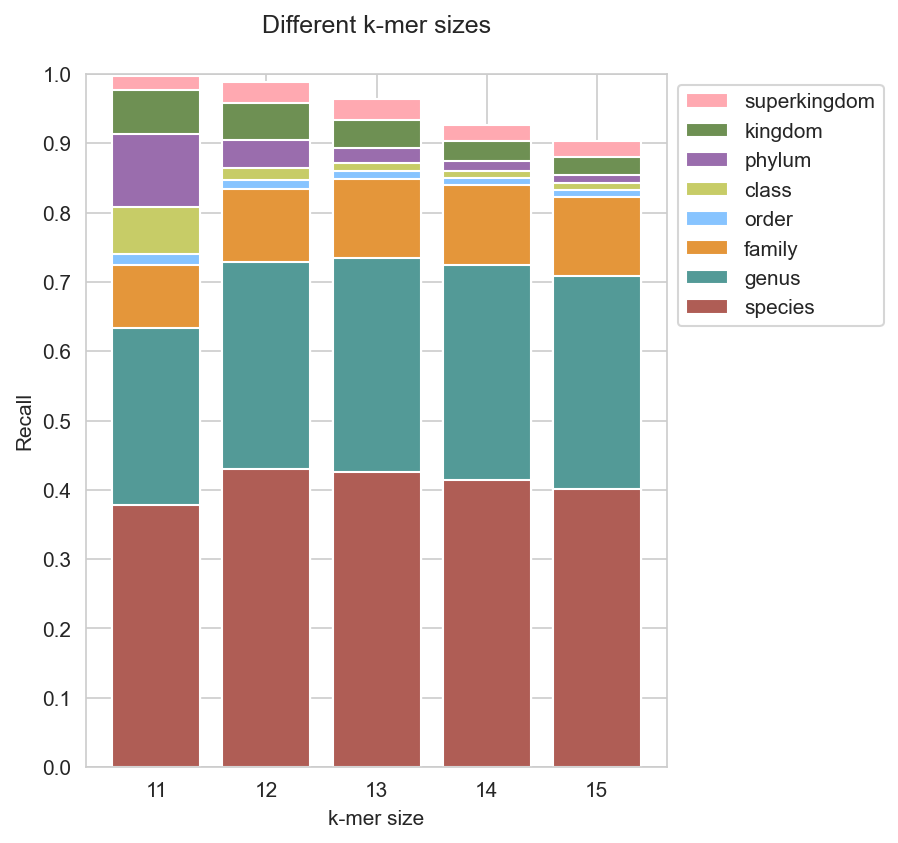

In [3]:
def plot_true_assigned_per_rank(df: pd.DataFrame, title: str = "", x_axis: str = "",
                                y_axis: str = "true assigned reads (%)", ranks: int = 8):
    ranks = ["superkingdom", "kingdom", "phylum", "class", "order", "family", "genus", "species"][-ranks:]
    colors = ["#ffa9b1", "#6e9053", "#9a6dad", "#c7cc67", "#87c4ff", "#e4963a", "#539a97", "#af5d55"]
    colors = colors[-len(ranks):]
    for rank, color in zip(ranks, colors):
        plt.bar(df["label"].astype(str), df[rank], label=rank, color=color, width=0.8)
    plt.legend(bbox_to_anchor=(1, 1), loc="upper left")
    plt.ylim(0, 1)
    plt.yticks(np.arange(0, 1.01, 0.1))
    plt.xlabel(x_axis)
    plt.ylabel(y_axis)
    plt.title(title, pad=20)
    plt.show()

plt.figure(figsize=(5, 6), dpi=150)
plot_true_assigned_per_rank(data_zymo_mock_recall, "Different k-mer sizes", "k-mer size", "Recall")

<Figure size 1200x900 with 0 Axes>

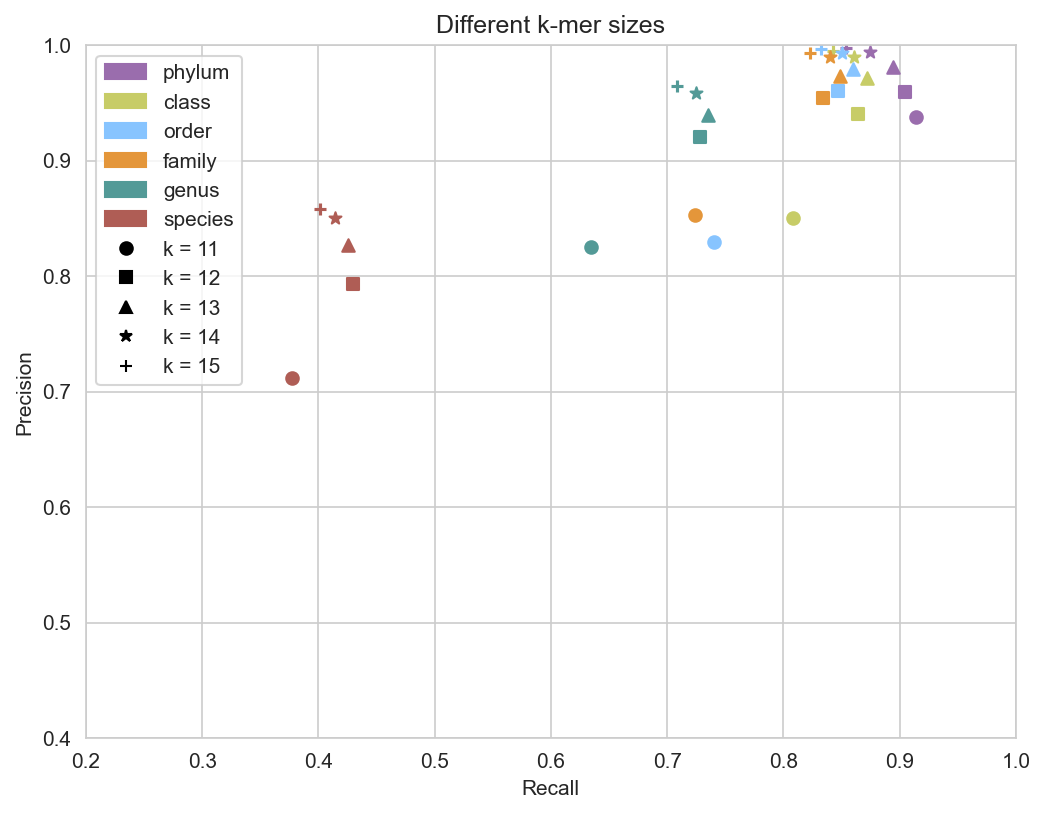

In [10]:
ranks = ["phylum", "class", "order", "family", "genus", "species"]
colors = ["#9a6dad", "#c7cc67", "#87c4ff", "#e4963a", "#539a97", "#af5d55"]
markers = ["o", "s", "^", "*", "+"]

# creating legends
handles_colors = []
handles_symbols = []

plt.figure(figsize=(8, 6), dpi=150)

for rank, color in zip(ranks, colors):
    handles_colors.append(Patch(color=color, label=rank))
    handles_symbols = []
    for marker, k_mer_size in zip(markers, data_zymo_mock["k-mer size"].unique()):
        handles_symbols.append(Line2D([], [], marker=marker, color="black", label="k = " + str(k_mer_size), linestyle="None"))
        data_filtered = data_zymo_mock[(data_zymo_mock["rank"] == rank) & (data_zymo_mock["k-mer size"] == k_mer_size)]
        plt.scatter(data_filtered["recall"], data_filtered["precision"], label=rank, color=color, marker=marker)

plt.xlim(0.2, 1)
plt.ylim(0.4, 1)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Different k-mer sizes")

plt.legend(handles=handles_colors + handles_symbols)
plt.show()

## Data zymoOral

In [5]:
# read table with paths to datasets and metadata
data_zymo_oral_metadata = pd.read_csv("datasets_zymo_oral_metadata.tsv", sep="\t", header=0).fillna("")
data_zymo_oral = pd.DataFrame()
data_zymo_oral_recall = pd.DataFrame()
for i, row in data_zymo_oral_metadata.iterrows():
    # read per taxon assignment files and keep taxa with at least one read assigned by the "OVO (1.00) read count cumulative" algorithm
    per_taxon_assignment = read_per_taxon_assignment(root + row.path, ovo_1_threshold=1)
    # classify taxa as true positive or false positive
    per_taxon_assignment = classify_assigned_taxa(per_taxon_assignment, true_taxons_zymo_oral)
    # calculate precision and recall
    per_taxon_assignment = get_precision_recall_for_algorithm(per_taxon_assignment, "OVO (1.00) kmer count (cumulative)", total_zymo_oral)
    per_taxon_assignment["k-mer size"] = row["kmer size"]
    data_zymo_oral = pd.concat([data_zymo_oral, per_taxon_assignment], ignore_index=True, axis=0)
    recall = per_taxon_assignment[["rank", "recall"]]\
                                 .melt(id_vars="rank").pivot_table(index=None, columns="rank", values="value")\
                                 .sort_values(by="value", axis=1, ascending=False).reset_index(drop=True)
    recall["label"] = row["kmer size"]
    data_zymo_oral_recall = pd.concat([data_zymo_oral_recall, recall], ignore_index=True, axis=0)
data_zymo_oral_recall

rank,superkingdom,phylum,kingdom,class,family,genus,order,species,label
0,0.999737,0.998865,0.995351,0.988037,0.962160,0.954568,0.795080,0.387010,11
1,0.999519,0.998624,0.994084,0.990193,0.981177,0.970876,0.807168,0.393308,12
2,0.998464,0.997613,0.992936,0.989951,0.982402,0.971515,0.807839,0.394279,13
3,0.997398,0.996098,0.991426,0.990064,0.982667,0.971342,0.808248,0.394570,14
4,0.997161,0.995464,0.990816,0.990234,0.982708,0.970961,0.808254,0.393644,15


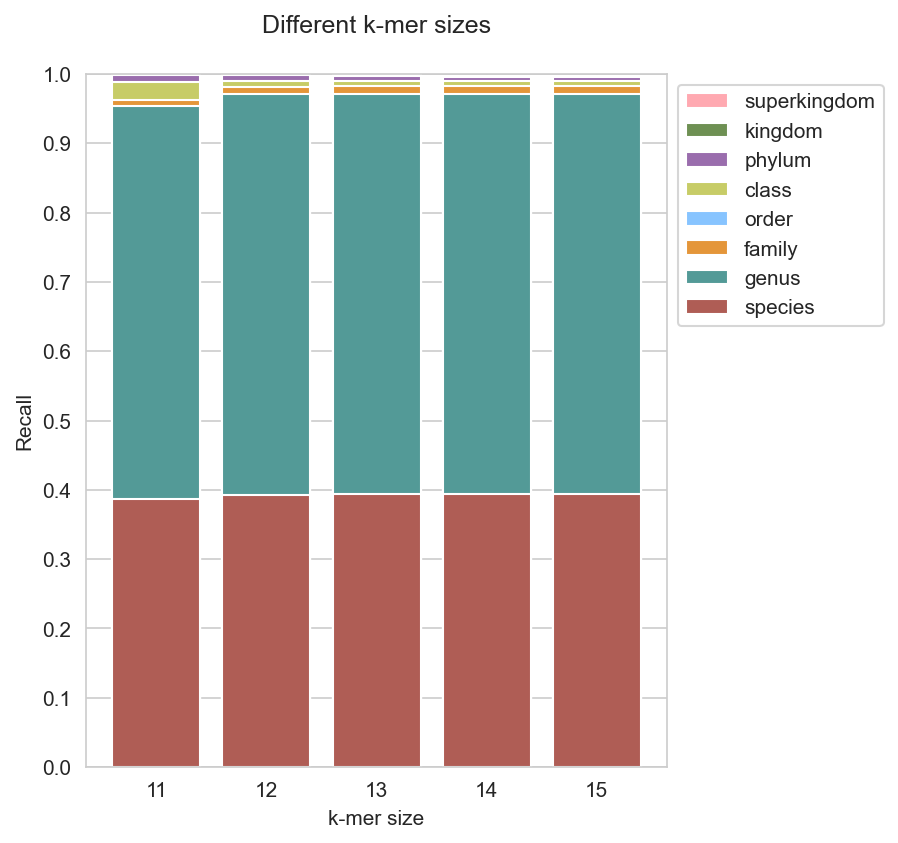

In [6]:
plt.figure(figsize=(5, 6), dpi=150)
plot_true_assigned_per_rank(data_zymo_oral_recall, "Different k-mer sizes", "k-mer size", "Recall")

<Figure size 1200x900 with 0 Axes>

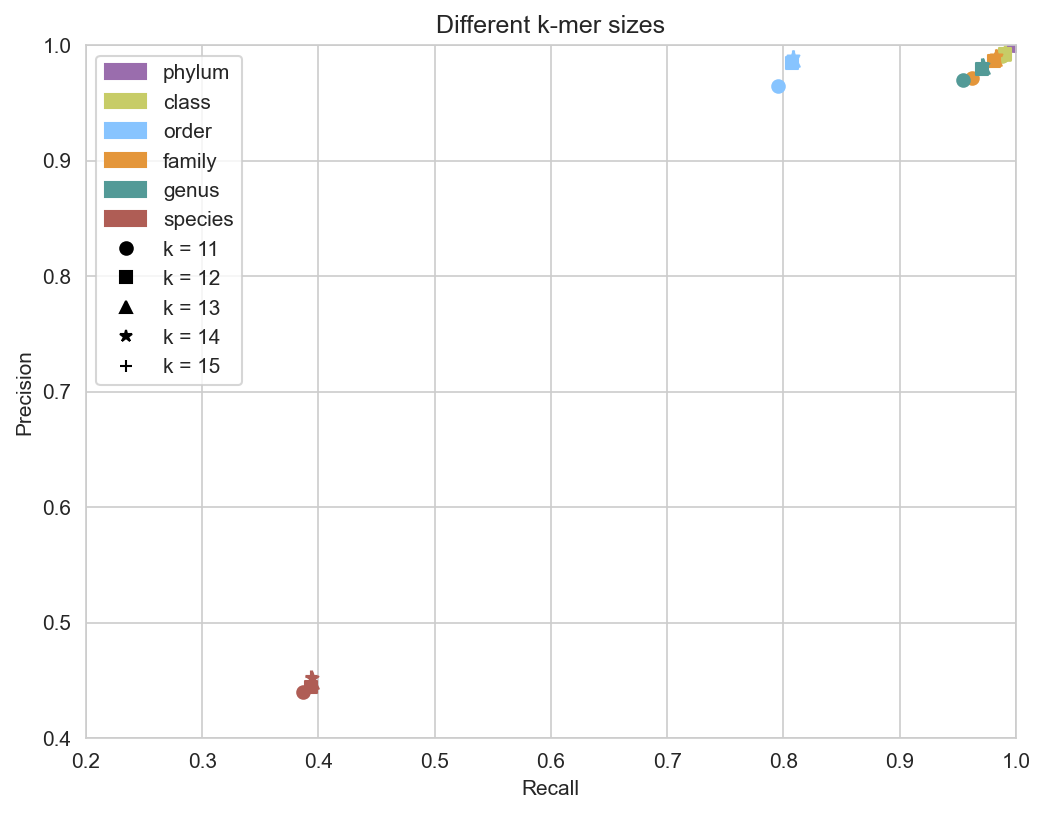

In [12]:
plt.figure(figsize=(8, 6), dpi=150)
ranks = ["phylum", "class", "order", "family", "genus", "species"]
colors = ["#9a6dad", "#c7cc67", "#87c4ff", "#e4963a", "#539a97", "#af5d55"]
markers = ["o", "s", "^", "*", "+"]

# creating legends
handles_colors = []
handles_symbols = []

plt.figure(figsize=(8, 6), dpi=150)

for rank, color in zip(ranks, colors):
    handles_colors.append(Patch(color=color, label=rank))
    handles_symbols = []
    for marker, k_mer_size in zip(markers, data_zymo_oral["k-mer size"].unique()):
        handles_symbols.append(Line2D([], [], marker=marker, color="black", label="k = " + str(k_mer_size), linestyle="None"))
        data_filtered = data_zymo_oral[(data_zymo_oral["rank"] == rank) & (data_zymo_oral["k-mer size"] == k_mer_size)]
        plt.scatter(data_filtered["recall"], data_filtered["precision"], label=rank, color=color, marker=marker)

plt.xlim(0.2, 1)
plt.ylim(0.4, 1)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Different k-mer sizes")

plt.legend(handles=handles_colors + handles_symbols)
plt.show()